## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
from tensorflow.keras.callbacks import EarlyStopping
import itertools

# 1. CARICAMENTO E PULIZIA DATI
df = pd.read_excel('Dataset-Project-Deep-Learning-SMRES-Unificato.xlsx')


In [2]:
# 1. Conversione della colonna Data in formato datetime
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y %H:%M:%S')

# 2. Estrazione dell'ora dalla colonna Ora (ad esempio "14:00" -> 14)
df['Ora'] = df['Ora'].str.split(':').str[0].astype(int)

# 3. Calcolo delle trasformazioni orarie
df['Day_sin'] = np.sin(2 * np.pi * df['Ora'] / 24)
df['Day_cos'] = np.cos(2 * np.pi * df['Ora'] / 24)

# 4. Costruzione della colonna date_time combinando la data (senza orario) e l'ora
df['date_time'] = pd.to_datetime(
    df['Data'].dt.strftime('%Y-%m-%d') + ' ' + df['Ora'].astype(str).str.zfill(2) + ':00:00',
    format='%Y-%m-%d %H:%M:%S'
)

# 5. Calcolo del timestamp in secondi dalla colonna date_time
timestamp_s = df['date_time'].map(pd.Timestamp.timestamp)

In [3]:
df['Data'].max()


Timestamp('2022-06-30 00:00:00')

In [4]:
data = df[['Potenza Uffici [W]','Temperatura [K]','Nuvolosità [%]','Irraggiamento [kWh/m2]','Day_sin','Day_cos']]

Definizione delle funzioni e delle finestre di windowing

In [5]:
def make_dataset(data, input_width, label_width, shift, batch_size, target_col="Potenza Uffici [W]"):
    # Converte il DataFrame in array numpy
    data_array = np.array(data, dtype=np.float32)
    total_window_size = input_width + shift
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data_array,
        targets=None,
        sequence_length=total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=batch_size
    )
    # Ottieni l'indice della colonna target
    target_col_index = data.columns.get_loc(target_col)
    
    def split_window(window):
        inputs = window[:, :input_width, :]
        # Seleziona solo la colonna target per le etichette:
        labels = window[:, input_width:input_width+label_width, target_col_index]
        # labels avrà forma (batch, label_width)
        return inputs, labels
    
    ds = ds.map(split_window)
    return ds

def create_sequences_df(df, input_width=24, out_steps=24, target_col="Potenza Uffici [W]"):
    sequences = []
    labels = []
    for i in range(len(df) - input_width - out_steps + 1):
        seq_input = df.iloc[i : i + input_width].values
        # Selezioniamo solo la colonna target
        seq_label = df.iloc[i + input_width : i + input_width + out_steps][target_col].values
        sequences.append(seq_input)
        labels.append(seq_label)
    sequences = np.array(sequences)
    labels = np.array(labels)
    # Per out_steps > 1 manteniamo la shape (N, out_steps)
    return sequences, labels

# Il modello, nel build_model, ha un output di 12 unità, quindi ora y_trainval ha shape (n_samples, 12)
def build_model(input_shape, lstm_units=64, dense_units=12, dropout_rate=0.0, learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.LSTM(lstm_units, dropout=dropout_rate),
        tf.keras.layers.Dense(dense_units)
    ])
    
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model



# 1. Suddivisione e standardizzazione dei dati
n = len(data)
train_data = data.iloc[:int(n*0.7)]
val_data   = data.iloc[int(n*0.7):int(n*0.9)]
test_data  = data.iloc[int(n*0.9):]

train_mean = train_data.mean()
train_std  = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data   = (val_data - train_mean) / train_std
test_data  = (test_data - train_mean) / train_std

# 2. Definizione dei parametri di windowing per la predizione sequence-to-sequence
input_width = 24   # lunghezza della sequenza di input (es. 24 ore)
label_width = 12   # lunghezza della sequenza target (predizione per le prossime 12 ore)
shift       = 24   # gap fra input e target 

total_window_size = input_width + shift  # lunghezza totale della finestra

Grid Search del modello di previsione degli uffici per 12 ore

In [6]:

# Creiamo le sequenze specificando il target (ad es. "Potenza Uffici [W]")

# Creazione delle sequenze per la grid search
X_train_uff, y_train_uff = create_sequences_df(train_data, input_width=24, out_steps=12, target_col="Potenza Uffici [W]")
X_val_uff,   y_val_uff   = create_sequences_df(val_data,   input_width=24, out_steps=12, target_col="Potenza Uffici [W]")

# Uniamo training e validation per la grid search
X_trainval_uff = np.concatenate([X_train_uff, X_val_uff], axis=0)
y_trainval_uff = np.concatenate([y_train_uff, y_val_uff], axis=0)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Grid search manuale
param_grid = {
    "lstm_units": [32, 64, 128],
    "dropout_rate": [0.0, 0.2],
    "learning_rate": [0.001, 0.0005],
    "batch_size": [16, 32, 64],
    "epochs": [100]  
}

# Genera tutte le combinazioni di parametri
keys_uff = param_grid.keys()
values_uff = param_grid.values()
param_combinations = [dict(zip(keys_uff, combo)) for combo in itertools.product(*values_uff)]

best_score_uff = -np.inf
best_params_uff = None
input_shape_uff = (X_trainval_uff.shape[1], X_trainval_uff.shape[2])  # Forma dell'input

for params in param_combinations:
    print(f"\nTesting parameters: {params}")
    
    try:
        # Costruisci e allena il modello
        model = build_model(
            input_shape=input_shape_uff,
            lstm_units=params['lstm_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            dense_units=12
        )
        
        history = model.fit(
            X_trainval_uff, y_trainval_uff,
            batch_size=params['batch_size'],
            epochs=params['epochs'],
            callbacks=[early_stopping],
            validation_split=0.2,  # Sostituisci con la tua strategia di validazione
            verbose=2
        )
        
        # Callcolo dello score migliore prendendo il minor valore di loss registrato (usiamo la validation loss)
        val_loss = np.min(history.history['val_loss']) 
        current_score = -val_loss  # Negativo per mantenere la stessa metrica
        
        if current_score > best_score_uff:
            best_score_uff = current_score
            best_params_uff = params
            print(f"Nuovo miglior punteggio: {best_score_uff:.4f}")
            
    except Exception as e:
        print(f"Fallito con parametri {params}: {str(e)}")
        continue

print("\nMigliori iperparametri:", best_params_uff)
print("Miglior punteggio (neg_MSE):", best_score_uff)



Testing parameters: {'lstm_units': 32, 'dropout_rate': 0.0, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 100}
Epoch 1/100
587/587 - 1s - 3ms/step - loss: 0.3395 - mean_absolute_error: 0.4376 - val_loss: 0.2772 - val_mean_absolute_error: 0.3902
Epoch 2/100
587/587 - 1s - 2ms/step - loss: 0.2224 - mean_absolute_error: 0.3463 - val_loss: 0.2216 - val_mean_absolute_error: 0.3394
Epoch 3/100
587/587 - 1s - 2ms/step - loss: 0.1981 - mean_absolute_error: 0.3205 - val_loss: 0.2117 - val_mean_absolute_error: 0.3281
Epoch 4/100
587/587 - 1s - 2ms/step - loss: 0.1878 - mean_absolute_error: 0.3095 - val_loss: 0.2149 - val_mean_absolute_error: 0.3301
Epoch 5/100
587/587 - 1s - 2ms/step - loss: 0.1806 - mean_absolute_error: 0.3017 - val_loss: 0.2030 - val_mean_absolute_error: 0.3155
Epoch 6/100
587/587 - 1s - 2ms/step - loss: 0.1750 - mean_absolute_error: 0.2957 - val_loss: 0.2101 - val_mean_absolute_error: 0.3233
Epoch 7/100
587/587 - 1s - 2ms/step - loss: 0.1694 - mean_absolute_error: 0.28

KeyboardInterrupt: 

Grid Search per il modello di previsione degli uffici autoregressivo di 1 h

In [ ]:
# Creazione delle sequenze per la grid search
X_train_uff_autoreg, y_train_uff_autoreg = create_sequences_df(train_data, input_width=24, out_steps=1, target_col="Potenza Uffici [W]")
X_val_uff_autoreg,   y_val_uff_autoreg   = create_sequences_df(val_data,   input_width=24, out_steps=1, target_col="Potenza Uffici [W]")

# Uniamo training e validation per la grid search
X_trainval_uff_autoreg = np.concatenate([X_train_uff_autoreg, X_val_uff_autoreg], axis=0)
y_trainval_uff_autoreg = np.concatenate([y_train_uff_autoreg, y_val_uff_autoreg], axis=0)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Grid search manuale
param_grid = {
    "lstm_units": [32, 64, 128],
    "dropout_rate": [0.0, 0.2],
    "learning_rate": [0.001, 0.0005],
    "batch_size": [16, 32, 64],
    "epochs": [100]  
}

# Genera tutte le combinazioni di parametri
keys_uff_autoreg = param_grid.keys()
values_uff_autoreg = param_grid.values()
param_combinations = [dict(zip(keys_uff_autoreg, combo)) for combo in itertools.product(*values_uff_autoreg)]

best_score_uff_autoreg = -np.inf
best_params_uff_autoreg = None
input_shape_uff_autoreg = (X_trainval_uff_autoreg.shape[1], X_trainval_uff_autoreg.shape[2])  # Forma dell'input

for params in param_combinations:
    print(f"\nTesting parameters: {params}")
    
    try:
        # Costruisci e allena il modello
        model = build_model(
            input_shape=input_shape_uff_autoreg,
            lstm_units=params['lstm_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            dense_units=1
        )
        
        history = model.fit(
            X_trainval_uff_autoreg, y_trainval_uff_autoreg,
            batch_size=params['batch_size'],
            epochs=params['epochs'],
            callbacks=[early_stopping],
            validation_split=0.2,  # Sostituisci con la tua strategia di validazione
            verbose=2
        )
        
        # Callcolo dello score migliore prendendo il minor valore di loss registrato (usiamo la validation loss)
        val_loss = np.min(history.history['val_loss']) 
        current_score = -val_loss  # Negativo per mantenere la stessa metrica
        
        #essendo la val_loss negativa ci va il > al posto del <
        if current_score > best_score_uff_autoreg:
            best_score_uff_autoreg = current_score
            best_params_uff_autoreg = params
            print(f"Nuovo miglior punteggio: {best_score_uff_autoreg:.4f}")
            
    except Exception as e:
        print(f"Fallito con parametri {params}: {str(e)}")
        continue

print("\nMigliori iperparametri:", best_params_uff_autoreg)
print("Miglior punteggio (neg_MSE):", best_score_uff_autoreg)

Grid search per il modello di previsione di 12 ore dell'irraggiamento

In [ ]:

# Creazione delle sequenze per la grid search
X_train_irr, y_train_irr = create_sequences_df(train_data, input_width=24, out_steps=12, target_col="Irraggiamento [kWh/m2]")
X_val_irr, y_val_irr   = create_sequences_df(val_data,   input_width=24, out_steps=12, target_col="Irraggiamento [kWh/m2]")

# Uniamo training e validation per la grid search
X_trainval_irr = np.concatenate([X_train_irr, X_val_irr], axis=0)
y_trainval_irr = np.concatenate([y_train_irr, y_val_irr], axis=0)

# Genera tutte le combinazioni di parametri
keys_irr = param_grid.keys()
values_irr = param_grid.values()
param_combinations = [dict(zip(keys_irr, combo)) for combo in itertools.product(*values_irr)]

best_score_irr = -np.inf
best_params_irr = None
input_shape_irr = (X_trainval_irr.shape[1], X_trainval_irr.shape[2])  # Forma dell'input
print("GridSearch per il modello dell'irraggiamento")
for params in param_combinations:
    print(f"\nTesting parameters: {params}")
    
    try:
        # Costruisci e allena il modello
        model = build_model(
            input_shape=input_shape_irr,
            lstm_units=params['lstm_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            dense_units=12
        )
        
        history = model.fit(
            X_trainval_irr, y_trainval_irr,
            batch_size=params['batch_size'],
            epochs=params['epochs'],
            callbacks=[early_stopping],
            validation_split=0.2,  # Sostituisci con la tua strategia di validazione
            verbose=2
        )
        
        # Callcolo dello score migliore prendendo il minor valore di loss registrato (usiamo la validation loss)
        val_loss = np.min(history.history['val_loss']) 
        current_score = -val_loss  # Negativo per mantenere la stessa metrica
        
        if current_score > best_score_irr:
            best_score_irr = current_score
            best_params_irr = params
            print(f"Nuovo miglior punteggio: {best_score_irr:.4f}")
            
    except Exception as e:
        print(f"Fallito con parametri {params}: {str(e)}")
        continue

print("\nMigliori iperparametri irraggiamento:", best_params_irr)
print("Miglior punteggio (neg_MSE):", best_score_irr)

Grid search per il modello di previsione di un ora dell'irraggiamento

In [ ]:
# Creazione delle sequenze per la grid search
X_train_irr_autoreg, y_train_irr_autoreg = create_sequences_df(train_data, input_width=24, out_steps=1, target_col="Irraggiamento [kWh/m2]")
X_val_irr_autoreg, y_val_irr_autoreg   = create_sequences_df(val_data,   input_width=24, out_steps=1, target_col="Irraggiamento [kWh/m2]")

# Uniamo training e validation per la grid search
X_trainval_irr_autoreg = np.concatenate([X_train_irr_autoreg, X_val_irr_autoreg], axis=0)
y_trainval_irr_autoreg = np.concatenate([y_train_irr_autoreg, y_val_irr_autoreg], axis=0)

# Genera tutte le combinazioni di parametri
keys_irr_autoreg = param_grid.keys()
values_irr_autoreg = param_grid.values()
param_combinations = [dict(zip(keys_irr_autoreg, combo)) for combo in itertools.product(*values_irr_autoreg)]

best_score_irr_autoreg = -np.inf
best_params_irr_autoreg = None
input_shape_irr_autoreg = (X_trainval_irr_autoreg.shape[1], X_trainval_irr_autoreg.shape[2])  # Forma dell'input
print("GridSearch per il modello dell'irraggiamento")
for params in param_combinations:
    print(f"\nTesting parameters: {params}")
    
    try:
        # Costruisci e allena il modello
        model = build_model(
            input_shape=input_shape_irr_autoreg,
            lstm_units=params['lstm_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            dense_units=1
        )
        
        history = model.fit(
            X_trainval_irr_autoreg, y_trainval_irr_autoreg,
            batch_size=params['batch_size'],
            epochs=params['epochs'],
            callbacks=[early_stopping],
            validation_split=0.2,  # Sostituisci con la tua strategia di validazione
            verbose=2
        )
        
        # Callcolo dello score migliore prendendo il minor valore di loss registrato (usiamo la validation loss)
        val_loss = np.min(history.history['val_loss']) 
        current_score = -val_loss  # Negativo per mantenere la stessa metrica
        
        if current_score > best_score_irr_autoreg:
            best_score_irr_autoreg = current_score
            best_params_irr_autoreg = params
            print(f"Nuovo miglior punteggio: {best_score_irr_autoreg:.4f}")
            
    except Exception as e:
        print(f"Fallito con parametri {params}: {str(e)}")
        continue

print("\nMigliori iperparametri irraggiamento:", best_params_irr_autoreg)
print("Miglior punteggio (neg_MSE):", best_score_irr_autoreg)

## Addestramento dei Modelli
**Modello 12 ore uffici**


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# 7. Costruzione del modello finale con i migliori iperparametri
final_model_uff = build_model(input_shape=input_shape_uff,
    lstm_units=best_params_uff["lstm_units"],
    dropout_rate=best_params_uff["dropout_rate"],
    learning_rate=best_params_uff["learning_rate"],
    dense_units=12  # questo parametro corrisponde al numero di uscite e quindi alle ore che devono essere predette
)
label_width_uff = 12
# Ricreiamo i dataset TF con il batch size ottimale dalla grid search
# La funzione make_dataset ha come paramertro di default target_col impostato sulla colonna uffici
train_ds_uff = make_dataset(train_data, input_width, label_width, shift, best_params_uff["batch_size"])
val_ds_uff   = make_dataset(val_data, input_width, label_width, shift, best_params_uff["batch_size"])
test_ds_uff  = make_dataset(test_data, input_width, label_width, shift, best_params_uff["batch_size"])

# 8. Addestramento del modello finale
final_model_uff.fit(
    train_ds_uff,
    epochs=best_params_uff["epochs"]+300,
    validation_data=val_ds_uff,
    verbose=1,
    callbacks=[early_stopping]
)
test_loss_uff, test_mae_uff = final_model_uff.evaluate(test_ds_uff, verbose=1)
print("Test loss:", test_loss_uff, "Test MAE:", test_mae_uff)

# salvo il modello addestrato
final_model_uff.save("final_model_uff.h5")

**Modello 1 ora uffici**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# 7. Costruzione del modello finale con i migliori iperparametri
final_model_uff_autoreg = build_model(input_shape=input_shape_uff_autoreg,
    lstm_units=best_params_uff_autoreg["lstm_units"],
    dropout_rate=best_params_uff_autoreg["dropout_rate"],
    learning_rate=best_params_uff_autoreg["learning_rate"],
    dense_units=1
)
label_width_uff_autoreg = 1
# Ricreiamo i dataset TF con il batch size ottimale dalla grid search
train_ds_uff_autoreg = make_dataset(train_data, input_width, label_width_uff_autoreg, shift, best_params_uff_autoreg["batch_size"])
val_ds_uff_autoreg   = make_dataset(val_data, input_width, label_width_uff_autoreg, shift, best_params_uff_autoreg["batch_size"])
test_ds_uff_autoreg  = make_dataset(test_data, input_width, label_width_uff_autoreg, shift, best_params_uff_autoreg["batch_size"])

# 8. Addestramento del modello finale
final_model_uff_autoreg.fit(
    train_ds_uff_autoreg,
    epochs=best_params_uff_autoreg["epochs"]+300,
    validation_data=val_ds_uff_autoreg,
    verbose=1,
    callbacks=[early_stopping]
)
test_loss_uff_autoreg, test_mae_uff_autoreg = final_model_uff_autoreg.evaluate(test_ds_uff_autoreg, verbose=1)
print("Test loss:", test_loss_uff_autoreg, "Test MAE:", test_mae_uff_autoreg)


# salvo il modello addestrato
final_model_uff_autoreg.save("final_model_uff_autoreg.h5")

**Modello 12 ore irraggiamento**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# 7. Costruzione del modello finale con i migliori iperparametri
final_model_irr = build_model(input_shape=input_shape_irr,
    lstm_units=best_params_irr["lstm_units"],
    dropout_rate=best_params_irr["dropout_rate"],
    learning_rate=best_params_irr["learning_rate"],
    dense_units=12
)
label_width_irr = 12
# Ricreiamo i dataset TF con il batch size ottimale dalla grid search
train_ds_irr = make_dataset(train_data, input_width, label_width_irr, shift, best_params_irr["batch_size"], target_col="Irraggiamento [kWh/m2]")
val_ds_irr   = make_dataset(val_data, input_width, label_width_irr, shift, best_params_irr["batch_size"], target_col="Irraggiamento [kWh/m2]")
test_ds_irr  = make_dataset(test_data, input_width, label_width_irr, shift, best_params_irr["batch_size"], target_col="Irraggiamento [kWh/m2]")

# 8. Addestramento del modello finale
final_model_irr.fit(
    train_ds_irr,
    epochs=best_params_irr["epochs"]+300,
    validation_data=val_ds_irr,
    verbose=1,
    callbacks=[early_stopping]
)
test_loss_irr, test_mae_irr = final_model_irr.evaluate(test_ds_irr, verbose=1)
print("Test loss:", test_loss_irr, "Test MAE:", test_mae_irr)


# salvo il modello addestrato
final_model_irr.save("final_model_irr.h5")

**Modello 1 ora irraggiamento**


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# 7. Costruzione del modello finale con i migliori iperparametri
final_model_irr_autoreg = build_model(input_shape=input_shape_irr_autoreg,
    lstm_units=best_params_irr_autoreg["lstm_units"],
    dropout_rate=best_params_irr_autoreg["dropout_rate"],
    learning_rate=best_params_irr_autoreg["learning_rate"],
    dense_units=1
)
label_width_irr_autoreg = 1
# Ricreiamo i dataset TF con il batch size ottimale dalla grid search
train_ds_irr_autoreg = make_dataset(train_data, input_width, label_width_irr_autoreg, shift, best_params_irr_autoreg["batch_size"], target_col="Irraggiamento [kWh/m2]")
val_ds_irr_autoreg   = make_dataset(val_data, input_width, label_width_irr_autoreg, shift, best_params_irr_autoreg["batch_size"], target_col="Irraggiamento [kWh/m2]")
test_ds_irr_autoreg  = make_dataset(test_data, input_width, label_width_irr_autoreg, shift, best_params_irr_autoreg["batch_size"], target_col="Irraggiamento [kWh/m2]")

# 8. Addestramento del modello finale
final_model_irr_autoreg.fit(
    train_ds_irr_autoreg,
    epochs=best_params_irr_autoreg["epochs"]+300,
    validation_data=val_ds_irr_autoreg,
    verbose=1,
    callbacks=[early_stopping]
)
test_loss_irr_autoreg, test_mae_irr_autoreg = final_model_irr_autoreg.evaluate(test_ds_irr_autoreg, verbose=1)
print("Test loss:", test_loss_irr_autoreg, "Test MAE:", test_mae_irr_autoreg)


# salvo il modello addestrato
final_model_irr_autoreg.save("final_model_irr_autoreg.h5")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(inputs, labels, predictions, target_index, max_subplots=5):
    """
    inputs: array numpy di shape (num_samples, input_width, num_features)
    labels: array numpy di shape (num_samples, label_width) oppure (num_samples, label_width, num_features)
    predictions: array numpy di shape (num_samples, label_width) oppure (num_samples, label_width, num_features)
    target_index: indice della colonna target (per inputs e, se presente, per labels/predictions a 3D)
    max_subplots: numero massimo di subplot da mostrare
    """
    num_samples = min(max_subplots, inputs.shape[0])
    input_width = inputs.shape[1]
    # Assumiamo che il label_width sia la seconda dimensione di labels (se 2D)
    label_width = labels.shape[1] if labels.ndim == 2 else labels.shape[1]
    
    plt.figure(figsize=(12, num_samples * 3))
    
    for n in range(num_samples):
        plt.subplot(num_samples, 1, n + 1)
        
        # Time axis per gli input: 0 ... input_width-1
        x_input = np.arange(input_width)
        plt.plot(x_input,
                 inputs[n, :, target_index],
                 label="Input", marker=".", linestyle="-")
        
        # Time axis per le label e le previsioni: input_width ... input_width+label_width-1
        x_future = np.arange(input_width, input_width + label_width)
        
        # Estrae le label: se labels è 3D, prendi la colonna target; se è 2D usala direttamente
        if labels.ndim == 3:
            label_values = labels[n, :, target_index]
        else:
            label_values = labels[n, :]
        
        plt.scatter(x_future,
                    label_values,
                    label="Label", color="green", s=64)
        
        # Estrae le previsioni in modo simile
        if predictions.ndim == 3:
            pred_values = predictions[n, :, target_index]
        else:
            pred_values = predictions[n, :]
        
        plt.scatter(x_future,
                    pred_values,
                    label="Prediction", marker="x", color="red",
                    s=64)
        
        if n == 0:
            plt.legend()
        plt.xlabel("Time step")
    
    plt.show()

In [ ]:
for test_inputs, test_labels in test_ds_uff_autoreg.take(1):
    test_predictions = final_model_uff_autoreg.predict(test_inputs)
    break

target_col = "Potenza Uffici [W]"
target_index = data.columns.get_loc(target_col)

plot_predictions(test_inputs.numpy(), test_labels.numpy(), test_predictions, target_index, max_subplots=5)

**Creazione del dataset con i dati reali per i successivi due mesi**

In [6]:
data2 = pd.read_excel('/Users/mattiacastiello/Desktop/ProgettiDeepLearning/TimeSeries/Dataset-Project-Deep-Learning-SMRES-Scartati.xlsx')

In [ ]:
data2['Data'].max()

In [ ]:
data2['Data'].min()

In [ ]:
data2.info()

In [7]:
dataset_filtered = data2[data2['Data'] <= '2022-09-01']


In [17]:
dataset_filtered['Data'].max()

Timestamp('2022-09-01 00:00:00')

In [28]:
dataset_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1512 entries, 0 to 1511
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data                    1512 non-null   datetime64[ns]
 1   Ora                     1512 non-null   object        
 2   Potenza Uffici [W]      1512 non-null   int64         
 3   Temperatura [K]         1512 non-null   float64       
 4   Nuvolosità [%]          1512 non-null   int64         
 5   Irraggiamento [kWh/m2]  1512 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 82.7+ KB


In [8]:
# 1. Conversione della colonna Data in formato datetime
dataset_filtered['Data'] = pd.to_datetime(dataset_filtered['Data'], format='%d.%m.%Y %H:%M:%S')

# 2. Estrazione dell'ora dalla colonna Ora (ad esempio "14:00" -> 14)
dataset_filtered['Ora'] = dataset_filtered['Ora'].str.split(':').str[0].astype(int)

# 3. Calcolo delle trasformazioni orarie
dataset_filtered['Day_sin'] = np.sin(2 * np.pi * dataset_filtered['Ora'] / 24)
dataset_filtered['Day_cos'] = np.cos(2 * np.pi * dataset_filtered['Ora'] / 24)

# 4. Costruzione della colonna date_time combinando la data (senza orario) e l'ora
dataset_filtered['date_time'] = pd.to_datetime(
    dataset_filtered['Data'].dt.strftime('%Y-%m-%d') + ' ' + dataset_filtered['Ora'].astype(str).str.zfill(2) + ':00:00',
    format='%Y-%m-%d %H:%M:%S'
)

# 5. Calcolo del timestamp in secondi dalla colonna date_time
timestamp_s = dataset_filtered['date_time'].map(pd.Timestamp.timestamp)

/var/folders/fj/jf8_1bs122n5rv0h0w7bdgh00000gn/T/ipykernel_1166/3639194801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_filtered['Data'] = pd.to_datetime(dataset_filtered['Data'], format='%d.%m.%Y %H:%M:%S')
/var/folders/fj/jf8_1bs122n5rv0h0w7bdgh00000gn/T/ipykernel_1166/3639194801.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_filtered['Ora'] = dataset_filtered['Ora'].str.split(':').str[0].astype(int)
/var/folders/fj/jf8_1bs122n5rv0h0w7bdgh00000gn/T/ipykernel_1166/3639194801.py:

In [9]:
dataset_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1512 entries, 0 to 1511
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data                    1512 non-null   datetime64[ns]
 1   Ora                     1512 non-null   int64         
 2   Potenza Uffici [W]      1512 non-null   int64         
 3   Temperatura [K]         1512 non-null   float64       
 4   Nuvolosità [%]          1512 non-null   int64         
 5   Irraggiamento [kWh/m2]  1512 non-null   float64       
 6   Day_sin                 1512 non-null   float64       
 7   Day_cos                 1512 non-null   float64       
 8   date_time               1512 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(3)
memory usage: 118.1 KB


In [10]:
from tensorflow.keras.models import load_model

# Carica i modelli salvati
final_model_irr_autoreg = load_model("final_model_irr_autoreg.h5")
final_model_irr         = load_model("final_model_irr.h5")
final_model_uff_autoreg = load_model("final_model_uff_autoreg.h5")
final_model_uff         = load_model("final_model_uff.h5")

Periodo di valutazione da 2022-07-01 23:00:00 a 2022-09-01 23:00:00
MAE (scala standardizzata) per Potenza Uffici [W]: 0.31625560761209637
MAE (scala standardizzata) per Irraggiamento [kWh/m2]: 0.04948103074802336


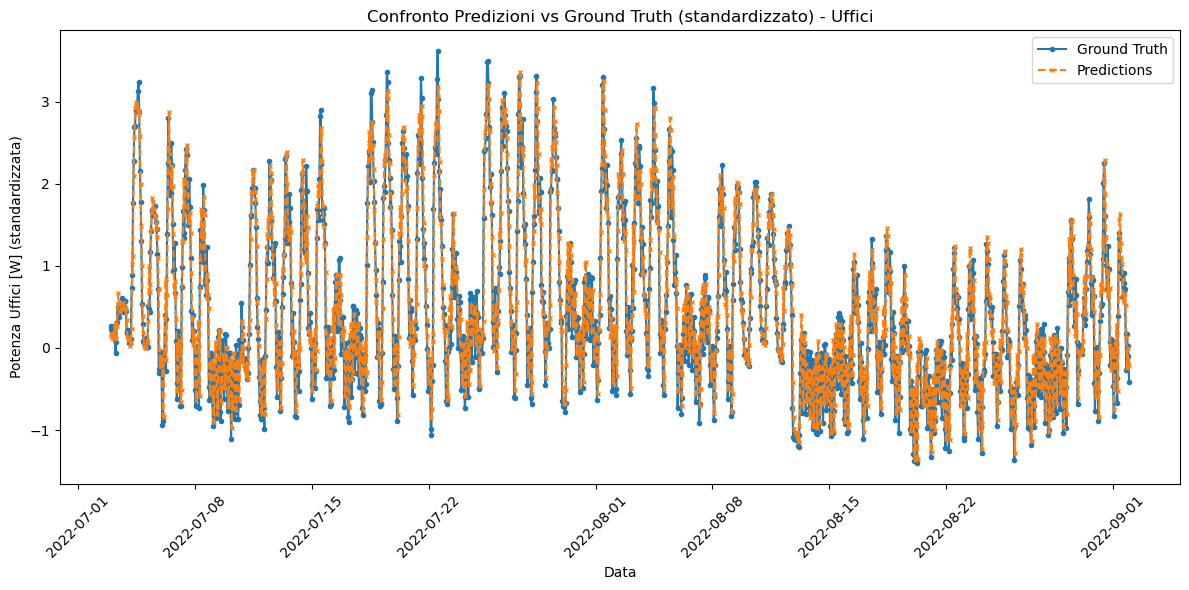

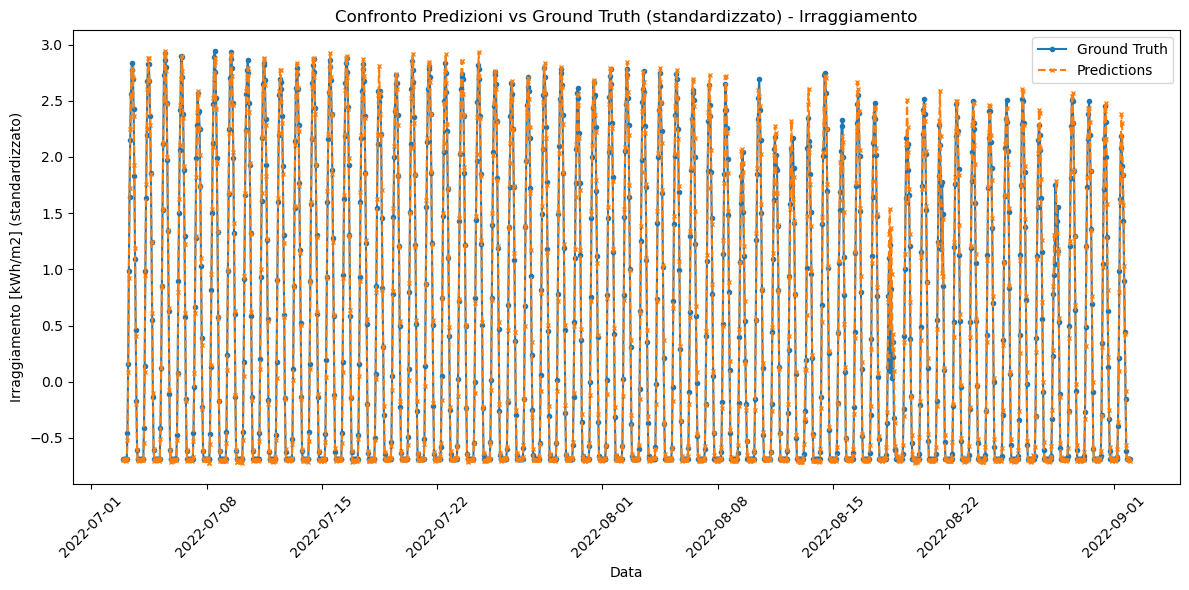

In [19]:
import pandas as pd
import numpy as np
from datetime import timedelta
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# 1. Carica o definisci i valori di train_mean e train_std usati in fase di addestramento.
#    Se li hai salvati in precedenza (ad es. su file), caricali qui.
#    Esempio: train_mean = pd.read_pickle("train_mean.pkl"), ecc.
# Per semplicità, qui li immaginiamo già disponibili come variabili in memoria.
# train_mean, train_std = ...

# 2. Assicuriamoci che dataset_filtered sia ordinato per data
dataset_filtered = dataset_filtered.sort_values("date_time").reset_index(drop=True)

# 3. Seleziona il periodo di valutazione (ultimi 2 mesi di dataset_filtered)
max_date = dataset_filtered["date_time"].max()
eval_start_date = max_date - pd.DateOffset(months=2)
evaluation_data = dataset_filtered[dataset_filtered["date_time"] >= eval_start_date].copy()

print("Periodo di valutazione da", evaluation_data["date_time"].min(), "a", evaluation_data["date_time"].max())

# 4. Definisci le features (stesso ordine del training)
features = ["Potenza Uffici [W]", "Temperatura [K]", "Nuvolosità [%]", 
            "Irraggiamento [kWh/m2]", "Day_sin", "Day_cos"]

# 5. Applica la *stessa* standardizzazione usata in training
#    NB: devi avere le stesse colonne in train_mean e train_std
evaluation_data[features] = (evaluation_data[features] - train_mean[features]) / train_std[features]

# 6. Parametri per la finestra (input_width = 24 ore)
input_width = 24

# 7. Carica i modelli autoregressivi salvati
final_model_uff_autoreg = load_model("final_model_uff_autoreg.h5")
final_model_irr_autoreg = load_model("final_model_irr_autoreg.h5")

# 8. Inizializziamo le liste per salvare previsioni e ground truth
predictions_uff = []
ground_truth_uff = []

predictions_irr = []
ground_truth_irr = []

# 9. Ciclo autoregressivo one-step ahead
for i in range(input_width, len(evaluation_data)):
    # Estrazione della finestra di input: ultime 24 righe dai dati (già standardizzati)
    window = evaluation_data.iloc[i - input_width:i][features].values
    window = window.reshape((1, input_width, len(features)))
    
    # Previsione per "Potenza Uffici [W]" con il modello autoregressivo
    pred_uff = final_model_uff_autoreg.predict(window, verbose=0)
    predictions_uff.append(pred_uff[0, 0])
    
    # Ground truth (già standardizzata) per la stessa riga
    ground_truth_uff.append(evaluation_data.iloc[i]["Potenza Uffici [W]"])
    
    # Previsione per "Irraggiamento [kWh/m2]" con il modello autoregressivo
    pred_irr = final_model_irr_autoreg.predict(window, verbose=0)
    predictions_irr.append(pred_irr[0, 0])
    
    # Ground truth (già standardizzata) per la stessa riga
    ground_truth_irr.append(evaluation_data.iloc[i]["Irraggiamento [kWh/m2]"])

# 10. Calcolo del MAE sulle serie standardizzate
mae_uff = np.mean(np.abs(np.array(predictions_uff) - np.array(ground_truth_uff)))
mae_irr = np.mean(np.abs(np.array(predictions_irr) - np.array(ground_truth_irr)))

print("MAE (scala standardizzata) per Potenza Uffici [W]:", mae_uff)
print("MAE (scala standardizzata) per Irraggiamento [kWh/m2]:", mae_irr)

# 11. Plot dei dati predetti vs dati reali (sempre in scala standardizzata)
time_axis = evaluation_data.iloc[input_width:]["date_time"]

# Plot "Potenza Uffici [W]"
plt.figure(figsize=(12, 6))
plt.plot(time_axis, ground_truth_uff, label="Ground Truth", marker="o", markersize=3)
plt.plot(time_axis, predictions_uff, label="Predictions", linestyle="--", marker="x", markersize=3)
plt.xlabel("Data")
plt.ylabel("Potenza Uffici [W] (standardizzata)")
plt.title("Confronto Predizioni vs Ground Truth (standardizzato) - Uffici")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot "Irraggiamento [kWh/m2]"
plt.figure(figsize=(12, 6))
plt.plot(time_axis, ground_truth_irr, label="Ground Truth", marker="o", markersize=3)
plt.plot(time_axis, predictions_irr, label="Predictions", linestyle="--", marker="x", markersize=3)
plt.xlabel("Data")
plt.ylabel("Irraggiamento [kWh/m2] (standardizzato)")
plt.title("Confronto Predizioni vs Ground Truth (standardizzato) - Irraggiamento")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Periodo di valutazione da 2022-07-01 23:00:00 a 2022-09-01 23:00:00
MAE (scala standardizzata) multi-step - Uffici: 0.4877744743332779
MAE (scala standardizzata) multi-step - Irraggiamento: 0.12965479224677331


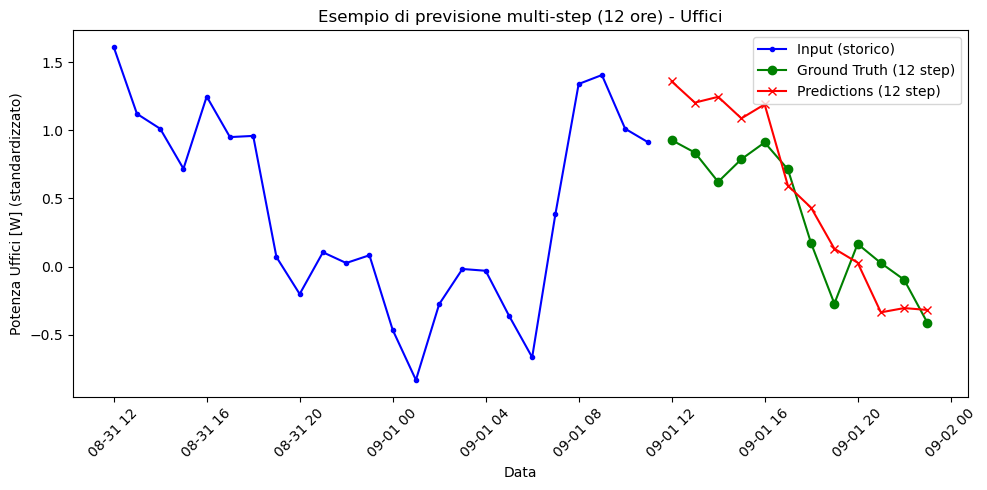

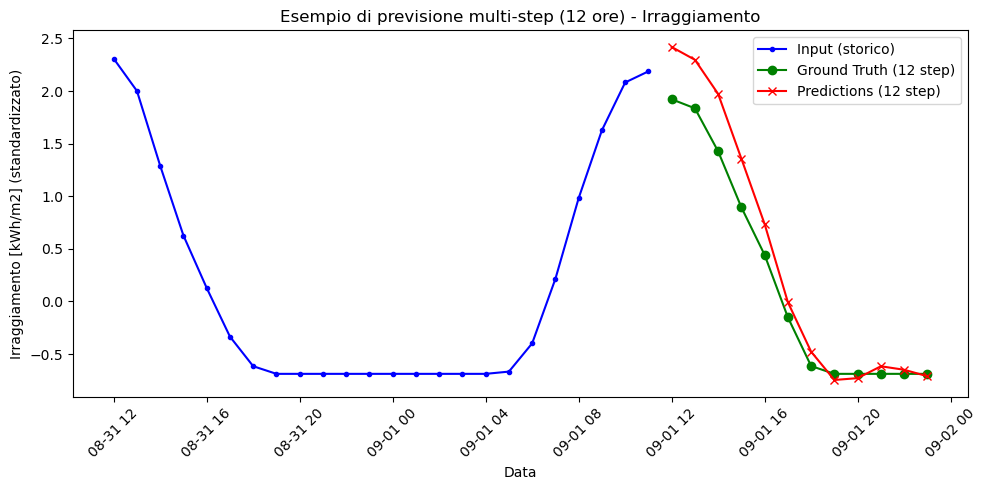

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# ==============================
# 1. Carica i valori di train_mean e train_std dal training
#    (o definiscili in variabili, se già in memoria).
# Esempio:
# train_mean = pd.read_pickle("train_mean.pkl")
# train_std  = pd.read_pickle("train_std.pkl")

# 2. Assicuriamoci che dataset_filtered sia ordinato cronologicamente
dataset_filtered = dataset_filtered.sort_values("date_time").reset_index(drop=True)

# 3. Seleziona il periodo di valutazione: ultimi 2 mesi del dataset
max_date = dataset_filtered["date_time"].max()
eval_start_date = max_date - pd.DateOffset(months=2)
evaluation_data = dataset_filtered[dataset_filtered["date_time"] >= eval_start_date].copy()

print("Periodo di valutazione da",
      evaluation_data["date_time"].min(),
      "a",
      evaluation_data["date_time"].max())

# 4. Definisci le stesse feature usate in training (stesso ordine!)
features = ["Potenza Uffici [W]", "Temperatura [K]", "Nuvolosità [%]", 
            "Irraggiamento [kWh/m2]", "Day_sin", "Day_cos"]

# 5. Applica la *stessa* standardizzazione usata in training
evaluation_data[features] = (evaluation_data[features] - train_mean[features]) / train_std[features]

# ==============================
# 6. Parametri della finestra
input_width = 24   # 24 ore di input
label_width = 12   # 12 step di output (es. 12 ore)

# ==============================
# 8. Creiamo liste per salvare previsioni e ground truth (multi-step)
predictions_uff = []   # conterrà array di shape (12,) per ogni finestra
ground_truth_uff = []  # conterrà array di shape (12,)

predictions_irr = []
ground_truth_irr = []

# ==============================
# 9. Ciclo su tutte le posizioni possibili, in modalità "sliding window"
#    - Da i = input_width fino a i = len(evaluation_data) - label_width
#    - Ad ogni step, estraiamo 24 ore di input e otteniamo 12 previsioni.
for i in range(input_width, len(evaluation_data) - label_width + 1):
    # Estrazione finestra di input (24 ore standardizzate)
    window = evaluation_data.iloc[i - input_width : i][features].values
    # Ridimensioniamo per matchare (batch=1, time=input_width, features)
    window = window.reshape((1, input_width, len(features)))
    
    # --- Previsione multi-step per Uffici ---
    pred_uff = final_model_uff.predict(window, verbose=0)  # shape (1, 12)
    predictions_uff.append(pred_uff[0])                    # shape (12,)

    # Ground truth: i 12 valori successivi reali (già standardizzati)
    true_uff = evaluation_data.iloc[i : i + label_width]["Potenza Uffici [W]"].values
    ground_truth_uff.append(true_uff)                      # shape (12,)

    # --- Previsione multi-step per Irraggiamento ---
    pred_irr = final_model_irr.predict(window, verbose=0)  # shape (1, 12)
    predictions_irr.append(pred_irr[0])                    # shape (12,)

    true_irr = evaluation_data.iloc[i : i + label_width]["Irraggiamento [kWh/m2]"].values
    ground_truth_irr.append(true_irr)

# ==============================
# 10. Convertiamo liste in array 2D e calcoliamo l'errore
predictions_uff = np.array(predictions_uff)     # shape (num_samples, 12)
ground_truth_uff = np.array(ground_truth_uff)   # shape (num_samples, 12)

predictions_irr = np.array(predictions_irr)
ground_truth_irr = np.array(ground_truth_irr)

# Calcolo del MAE (scala standardizzata) su tutti i punti
mae_uff = np.mean(np.abs(predictions_uff - ground_truth_uff))
mae_irr = np.mean(np.abs(predictions_irr - ground_truth_irr))

print("MAE (scala standardizzata) multi-step - Uffici:", mae_uff)
print("MAE (scala standardizzata) multi-step - Irraggiamento:", mae_irr)



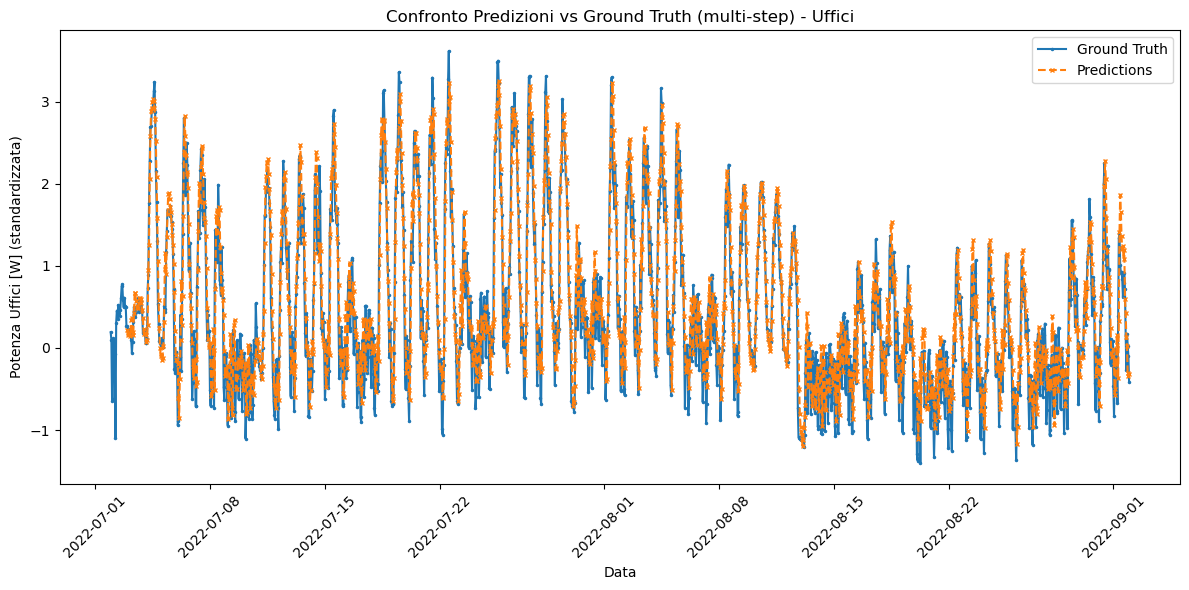

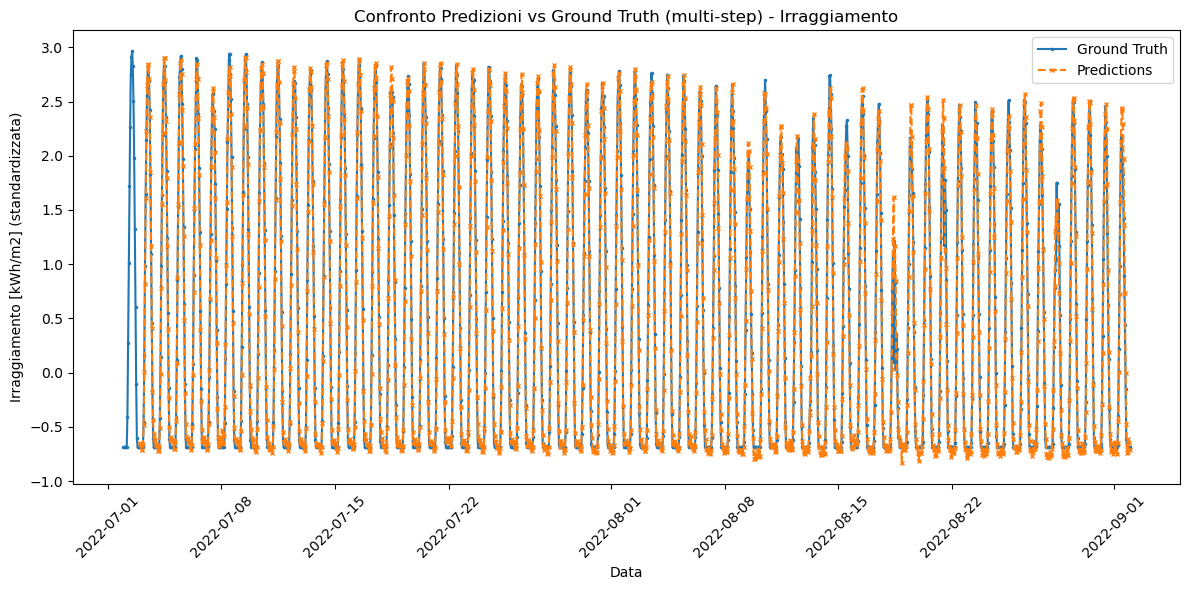

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Supponiamo che:
# 1) evaluation_data sia già ordinato cronologicamente
# 2) Abbiamo predictions_uff e predictions_irr di shape (num_samples, 12)
# 3) input_width = 24, label_width = 12
# 4) full_gt_uff = evaluation_data["Potenza Uffici [W]"].values
#    e full_gt_irr = evaluation_data["Irraggiamento [kWh/m2]"].values
#    (in scala standardizzata o originale, a seconda delle tue preferenze)
# 5) length = len(evaluation_data)

length = len(evaluation_data)

# --- Potenza Uffici ---
full_pred_uff = np.full(length, np.nan)  # array vuoto di dimensione "length"
full_gt_uff = evaluation_data["Potenza Uffici [W]"].values

num_samples_uff = predictions_uff.shape[0]

for i_input in range(num_samples_uff):
    i = input_width + i_input
    for step in range(label_width):  # 0..11
        t = i + step
        full_pred_uff[t] = predictions_uff[i_input, step]

# --- Irraggiamento ---
full_pred_irr = np.full(length, np.nan)  # array vuoto di dimensione "length"
full_gt_irr = evaluation_data["Irraggiamento [kWh/m2]"].values

num_samples_irr = predictions_irr.shape[0]

for i_input in range(num_samples_irr):
    i = input_width + i_input
    for step in range(label_width):
        t = i + step
        full_pred_irr[t] = predictions_irr[i_input, step]

# --- Plot: Potenza Uffici [W] ---
time_axis = evaluation_data["date_time"]

plt.figure(figsize=(12, 6))
plt.plot(time_axis, full_gt_uff, label="Ground Truth", marker=".", markersize=3)
plt.plot(time_axis, full_pred_uff, label="Predictions", linestyle="--", marker="x", markersize=3)
plt.xlabel("Data")
plt.ylabel("Potenza Uffici [W] (standardizzata)")  # o in scala originale se hai già invertito
plt.title("Confronto Predizioni vs Ground Truth (multi-step) - Uffici")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Plot: Irraggiamento [kWh/m2] ---
plt.figure(figsize=(12, 6))
plt.plot(time_axis, full_gt_irr, label="Ground Truth", marker=".", markersize=3)
plt.plot(time_axis, full_pred_irr, label="Predictions", linestyle="--", marker="x", markersize=3)
plt.xlabel("Data")
plt.ylabel("Irraggiamento [kWh/m2] (standardizzata)")
plt.title("Confronto Predizioni vs Ground Truth (multi-step) - Irraggiamento")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()